In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/bis_dp_search_export_20231210-174327.csv", skiprows=3)

In [3]:
data = data[["TIME_PERIOD:Period", "OBS_VALUE:Value"]]

In [4]:
data = data.rename(columns={"OBS_VALUE:Value":"Price", "TIME_PERIOD:Period":"Time"})

In [5]:
#data = data[15:]

In [6]:
data.Time = pd.to_datetime(data.Time)

<Axes: xlabel='Time'>

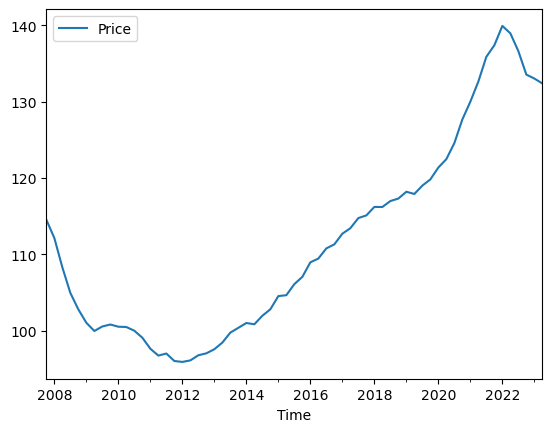

In [7]:
data.plot(x="Time", y="Price")

In [8]:
pd.date_range(start=data.Time.iloc[0], end=data.Time.iloc[-1])

DatetimeIndex(['2007-12-31', '2008-01-01', '2008-01-02', '2008-01-03',
               '2008-01-04', '2008-01-05', '2008-01-06', '2008-01-07',
               '2008-01-08', '2008-01-09',
               ...
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-24',
               '2023-06-25', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', length=5661, freq='D')

## Interpolated Series for more data

In [9]:
time_series = pd.DataFrame()

In [10]:
time_series["Time"] = pd.date_range(start=data.Time.iloc[0], end=data.Time.iloc[-1])

In [11]:
time_series = time_series.merge(data, how="left", on="Time")

In [12]:
time_series = time_series.Price.interpolate()

<Axes: >

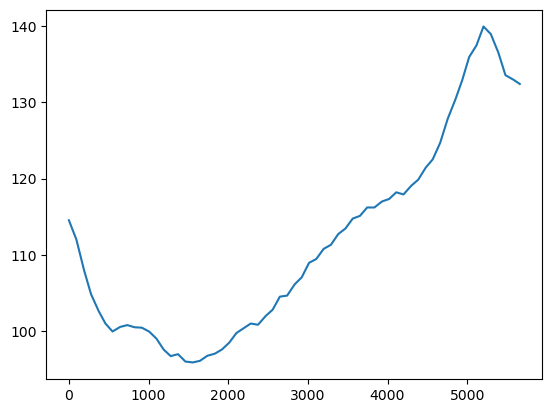

In [13]:
time_series.plot(x="Time", y="Price")

In [14]:
# standardize series
time_series = time_series = (time_series - np.mean(time_series)) / np.std(time_series)

In [15]:
train_size = int(len(time_series)*0.85)

In [16]:
train, test = time_series[:train_size], time_series[train_size:]

In [17]:
window_size = 50

In [18]:
test[train_size+1]

1.3810842820810971

In [19]:
train_size

4811

In [20]:
len(test)-window_size

800

In [21]:
X_train, y_train = [],[]
for i in range(len(train)-window_size):
  X_train.append(train[i:(i+window_size)])
  y_train.append(train[i+window_size])

X_test, y_test = [],[]
for i in range(len(test)-window_size):
  X_test.append(test[i:(i+window_size)])
  y_test.append(test[train_size+i+window_size])


In [22]:
X_train = torch.Tensor(np.array(X_train))
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = torch.Tensor(np.array(y_train))
y_train = y_train.reshape(y_train.shape[0], 1)

In [23]:
X_test = torch.Tensor(np.array(X_test))
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = torch.Tensor(np.array(y_test))
y_test = y_test.reshape(y_test.shape[0], 1)

In [24]:
class LSTM(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size=window_size, hidden_size=128)#, dropout=0.05, num_layers=4)
    self.fc1 = nn.Linear(in_features=128, out_features=10) 
    self.fc2 = nn.Linear(in_features=10, out_features=1)

  def forward(self, input: torch.Tensor):
    #input_trans = input.view(len(input), 1)
    lstm_out, _ = self.lstm(input)
    #lstm_out = nn.functional.sigmoid(lstm_out)
    lstm_out = self.fc1(lstm_out)
    #lstm_out = nn.functional.sigmoid(lstm_out)
    lstm_out = self.fc2(lstm_out)
    prediction = lstm_out#[-1]
    return prediction


In [25]:
model = LSTM()

In [26]:
criterion = nn.MSELoss()
optimizier = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              92,160
├─Linear: 1-2                            1,290
├─Linear: 1-3                            11
Total params: 93,461
Trainable params: 93,461
Non-trainable params: 0

In [28]:
for epoch in range(75):
  batch_loss = 0
  batch_labels = []
  batch_outputs = []
  batch_loss = 0
  for ix, x in enumerate(X_train):
    input, label = x, y_train[ix].reshape([1,1])
    output = model(input)
    batch_loss += criterion(label, output)
    if ix % 50 == 49:
      #print(batch_loss)
      batch_loss.mean().backward()
      batch_loss = 0
      optimizier.step()
      optimizier.zero_grad()
       

    #print(loss.item())
  #print(batch_loss/len(X_train))



In [ ]:
test_predictions = []
for x in X_test:
  test_predictions.append(model(x).item())

In [ ]:
train_predictions = []
for x in X_train:
  train_predictions.append(model(x).item())

In [ ]:
train_predictions = pd.Series(train_predictions, index=[i for i in range(window_size, (window_size+len(train_predictions)))])

In [ ]:
test_predictions = pd.Series(test_predictions, index=[i for i in range((train_size+window_size), (train_size+window_size+len(test_predictions)))])

In [ ]:
test_predictions

3054    0.440324
3055    0.441322
3056    0.442320
3057    0.443317
3058    0.444310
          ...   
4287    0.695231
4288    0.695211
4289    0.695192
4290    0.695172
4291    0.695153
Length: 1238, dtype: float64

In [ ]:
test_y = pd.Series(y_test.reshape(-1).tolist(), index=[i for i in range((train_size+window_size), (train_size+window_size+len(test_predictions)))])

<Axes: >

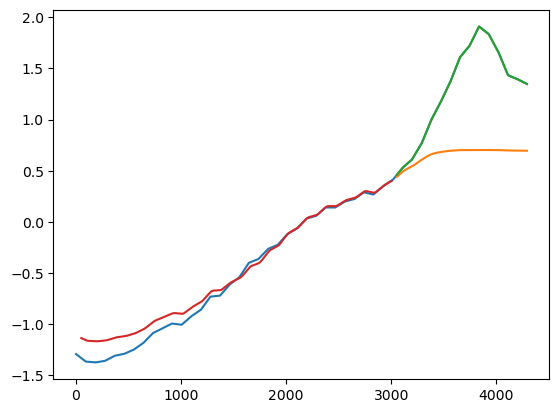

In [ ]:
time_series.plot()
test_predictions.plot()
test_y.plot()
train_predictions.plot()